## Import

In [119]:
import os,sys 
import re

import time
from tqdm.notebook import tqdm

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import tensorflow as tf
from tensorflow.keras import layers

from sklearn.preprocessing import minmax_scale
from scipy.stats import entropy

import soundfile
import librosa
import librosa.display
import noisereduce

img_height, img_width = 48, 128
BUFFER_SIZE = 1000
BATCH_SIZE = 32
SIGNAL_LENGTH = 5 # seconds
SAMPLE_RATE = 16384
SPEC_SHAPE = (48, 128) # height x width
FMIN = 500
FMAX = 12500
sample_rate = 16384
sample_length = 2

input_dir = 'basic_test/birds/'
output_dir = 'basic_test/melspectrogram_dataset/'
model_dir = 'basic_test/'
soundscape_dir = 'basic_test/'

## Audio GAN

### Load data

In [139]:
# Get mel_spec
def get_mel_spec(sig):
    hop_length = int(SIGNAL_LENGTH * SAMPLE_RATE / (SPEC_SHAPE[1] - 1))
    mel_spec = librosa.feature.melspectrogram(y=sig, 
                                              sr=SAMPLE_RATE, 
                                              n_fft=1024, 
                                              hop_length=hop_length, 
                                              n_mels=SPEC_SHAPE[0], 
                                              fmin=FMIN, 
                                              fmax=FMAX)

    mel_spec = librosa.power_to_db(mel_spec, ref=np.max) 

    # Normalize
    mel_spec -= mel_spec.min()
    mel_spec /= mel_spec.max()
    
    return mel_spec

def extract_noise(sig, step=2, size=5, verbose=False):
    # Get mel spectogram
    mel_spec = get_mel_spec(sig)
    
    # Column wise percentage
    mel_spec = np.nan_to_num(mel_spec/(np.sum(mel_spec, axis=0)+1e-6))
    # Remove columns with only 0
    mel_spec = mel_spec.T[~np.all(mel_spec == 0, axis=0)]
    # Split into chunks
    mel_splits = [mel_spec[i : i + size] for i in range(0, len(mel_spec), step)]

    entropy_splits = []
    
    for split in mel_splits:
        entropy_scores = [entropy(x) for x in split]
        entropy_splits.append((min(entropy_scores), np.mean(entropy_scores)))

    l = [sum(x) for x in entropy_splits] 
    
    try:
        l = l.index(max(l))
    except ValueError:
        return None
    
    if verbose==True:
        print('N splits:', len(mel_splits))
        print('Best split:', l)
    
    a = size/mel_spec.shape[0]
    b = step*l/mel_spec.shape[0]
    c = round(sig.shape[0]*b)
    d = round(sig.shape[0]*a)
    #breakpoint()
    noise = sig[c:c+d]
    
    return noise

def reduce_noise(sig, use_tensorflow=True, **kwargs):
    noise = extract_noise(sig, **kwargs)
    return noisereduce.reduce_noise(sig, noise, use_tensorflow=use_tensorflow, verbose=False)

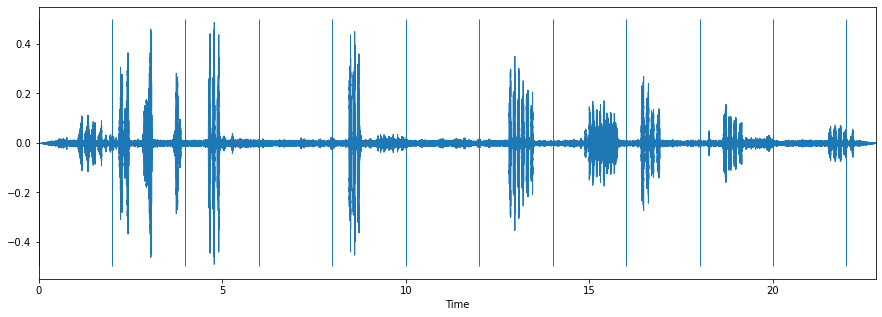

373440

In [140]:
audio_path = input_dir + 'amerob/XC75498.ogg'

sig, rate = librosa.load(audio_path, sr=sample_rate, offset=None)
plt.figure(figsize=(15, 5))
librosa.display.waveplot(sig, sr=sample_rate)
plt.vlines(range(0,24, sample_length),-.5,.5, linewidth=1)
plt.show()
len(sig)

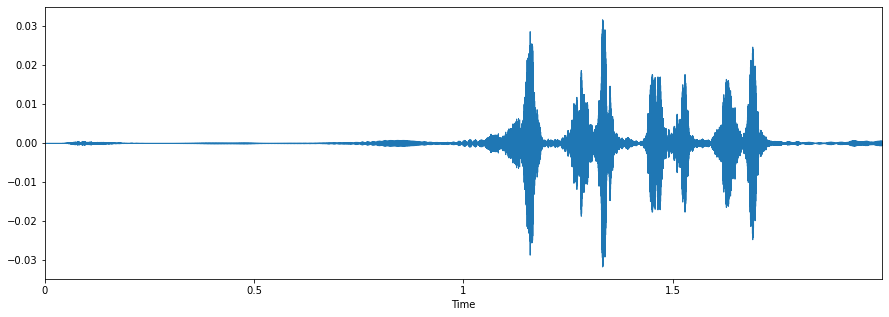

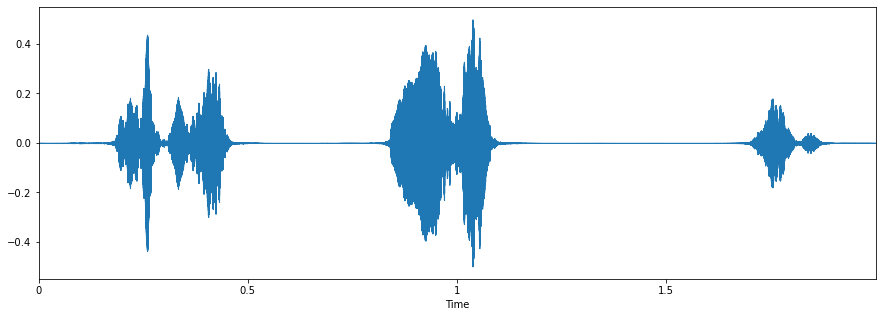

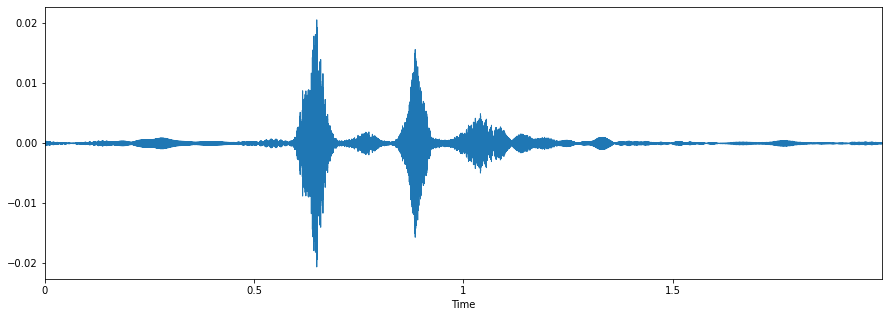

In [143]:
n = np.floor_divide(len(sig), rate * sample_length) + 1
sig = reduce_noise(sig, step=2, size=5, verbose=False)
vec = sig.copy()
vec.resize(n * rate * sample_length)
vec = vec.reshape(n, rate * sample_length)

for v in vec[:3]:
    plt.figure(figsize=(15, 5))
    librosa.display.waveplot(v, sr=16384)
    plt.show()

In [145]:
# Load metadata file
train = pd.read_csv('train_metadata.csv',)

file_list = train.loc[train['primary_label'] == 'amerob']['filename'].to_numpy()

segments = []

for file in tqdm(file_list):
    audio_path = input_dir + 'amerob/' + file
    sig, rate = librosa.load(audio_path, sr=sample_rate, offset=None)

    n = np.floor_divide(len(sig), rate * sample_length) + 1
    sig = reduce_noise(sig, step=2, size=5, verbose=False)

    vec = sig.copy()
    vec.resize(n * rate * sample_length)
    vec = vec.reshape(n, rate * sample_length)

    segments.append(vec)

segments = np.concatenate(segments, axis=0)
np.save('amerob', segments)
print(segments.shape)

  0%|          | 0/481 [00:00<?, ?it/s]

(17896, 32768)


## Load again

In [160]:
segments = np.load(path + 'amerob.npy')

In [170]:
audio_ds = tf.data.Dataset.from_tensor_slices(segments.reshape(-1,sample_rate*sample_length,1)).batch(50)

### Make model

In [172]:
def make_generator_model():
    model = tf.keras.Sequential()
    model.add(layers.Dense(64*256, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Reshape((64, 256)))
    assert model.output_shape == (None, 64, 256)

    model.add(layers.Conv1DTranspose(128, 25, strides=1, padding='same', use_bias=False))
    assert model.output_shape == (None, 64, 128)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv1DTranspose(64, 25, strides=4, padding='same', use_bias=False))
    assert model.output_shape == (None, 256, 64)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv1DTranspose(32, 25, strides=4, padding='same', use_bias=False))
    assert model.output_shape == (None, 1024, 32)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    
    model.add(layers.Conv1DTranspose(16, 25, strides=4, padding='same', use_bias=False))
    assert model.output_shape == (None, 4096, 16)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv1DTranspose(8, 25, strides=4, padding='same', use_bias=False))
    assert model.output_shape == (None, 16384, 8)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv1DTranspose(1, 25, strides=2, padding='same', use_bias=False, activation='tanh'))
    assert model.output_shape == (None, 16384*2, 1)

    return model

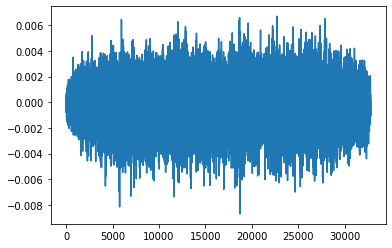

In [173]:
generator = make_generator_model()

noise = tf.random.normal([1, 100])
generated_audio = generator(noise, training=False)
plt.plot(generated_audio[0, :, 0])

In [174]:
def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(layers.Conv1D(64, 25, strides=4, padding='same',
                                     input_shape=[16384*2, 1]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv1D(128, 25, strides=4, padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv1D(256, 25, strides=4, padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv1D(512, 25, strides=4, padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())
    model.add(layers.Dense(1))

    return model

In [175]:
discriminator = make_discriminator_model()
decision = discriminator(generated_audio)
print(decision)

tf.Tensor([[-3.478275e-05]], shape=(1, 1), dtype=float32)


### Loss

In [ ]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

In [ ]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

checkpoint_dir = 'GAN/training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

### Train

In [176]:
EPOCHS = 100
noise_dim = 100
num_examples_to_generate = 16

seed = tf.random.normal([num_examples_to_generate, noise_dim])

In [177]:
@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training=True)

        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

In [178]:
def train(dataset, epochs):
    for epoch in range(epochs):
    start = time.time()

        for image_batch in tqdm(dataset):
            train_step(image_batch)

        # Save the model every 5 epochs
        if (epoch + 1) % 5 == 0:
        #  checkpoint.save(file_prefix = checkpoint_prefix)

            noise = tf.random.normal([1, 100])
            generated_audio = generator(noise, training=False)
            plt.plot(generated_audio[0, :, 0])
            plt.show()

    print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

In [179]:
tf.device('/device:GPU:0')


Time for epoch 1 is 111.84096479415894 sec



Time for epoch 2 is 109.0386049747467 sec



Time for epoch 3 is 108.38091802597046 sec



Time for epoch 4 is 108.62097501754761 sec


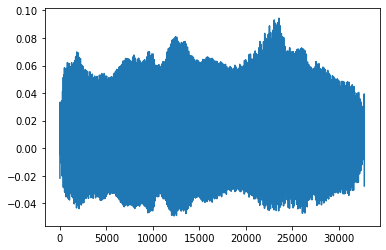

Time for epoch 5 is 143.64375686645508 sec



Time for epoch 6 is 109.02593278884888 sec



Time for epoch 7 is 109.42046928405762 sec



Time for epoch 8 is 143.38529658317566 sec



Time for epoch 9 is 108.30031943321228 sec


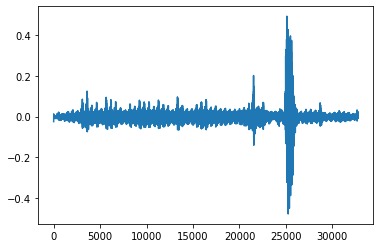

Time for epoch 10 is 108.51818799972534 sec



Time for epoch 11 is 143.358008146286 sec



Time for epoch 12 is 143.32557463645935 sec



Time for epoch 13 is 109.2655553817749 sec



Time for epoch 14 is 109.42752528190613 sec


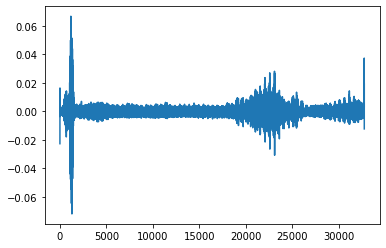

Time for epoch 15 is 109.57876133918762 sec



Time for epoch 16 is 109.43641972541809 sec



Time for epoch 17 is 143.42375659942627 sec



Time for epoch 18 is 143.3882143497467 sec



Time for epoch 19 is 109.57566952705383 sec


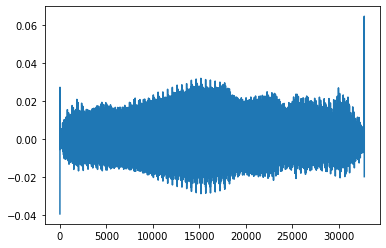

Time for epoch 20 is 143.64124298095703 sec



Time for epoch 21 is 108.05836486816406 sec



Time for epoch 22 is 143.3644106388092 sec



Time for epoch 23 is 143.34489965438843 sec



Time for epoch 24 is 108.86680674552917 sec


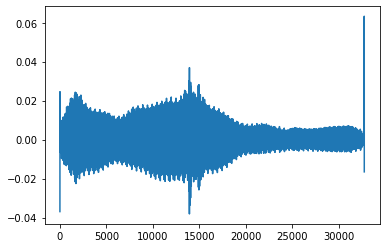

Time for epoch 25 is 108.67512607574463 sec


KeyboardInterrupt: ignored

In [180]:
train(audio_ds, EPOCHS)

## Export

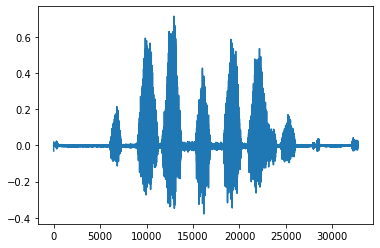

In [187]:
    noise = tf.random.normal([1, 100])
    generated_audio = generator(noise, training=False)
    plt.plot(generated_audio[0, :, 0])
    plt.show()

In [188]:
soundfile.write(path + 'bird_test' + str(np.array(noise)[0,0])[3:] + '.wav', np.array(generated_audio[0, :, 0]), 44100, 'PCM_24')

# Spec GAN

### Load Data

In [ ]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    output_dir,
    validation_split=0,
    label_mode=None,
    seed=123,
    image_size=(img_height, img_width),
    batch_size=32,
    color_mode="grayscale")

Found 6600 files belonging to 1 classes.


In [ ]:
normalization_layer = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)
train_ds = train_ds.map(lambda x: (normalization_layer(x)))

## Make Model

### Make Generator

In [ ]:
def make_generator_model():
    model = tf.keras.Sequential()
    model.add(layers.Dense(8*8*256, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Reshape((8, 8, 256)))
    assert model.output_shape == (None, 8, 8, 256)

    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    assert model.output_shape == (None, 8, 8, 128)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(3, 4), padding='same', use_bias=False))
    assert model.output_shape == (None, 24, 32, 64)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(32, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 48, 64, 32)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    
    model.add(layers.Conv2DTranspose(1, (5, 5), strides=(1, 2), padding='same', use_bias=False, activation='tanh'))
    assert model.output_shape == (None, 48, 128, 1)

    return model

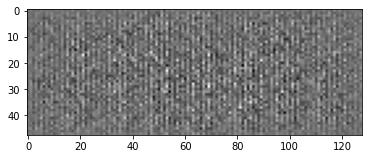

In [ ]:
generator = make_generator_model()

noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)

plt.imshow(generated_image[0, :, :, 0], cmap='gray')

### Make Discriminator

In [ ]:
def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same',
                                     input_shape=[48, 128, 1]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())
    model.add(layers.Dense(1))

    return model

In [ ]:
discriminator = make_discriminator_model()
decision = discriminator(generated_image)
print (decision)

tf.Tensor([[-0.0007716]], shape=(1, 1), dtype=float32)


### Loss

In [ ]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

In [ ]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

checkpoint_dir = 'GAN/training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

## Train

In [ ]:
EPOCHS = 50
noise_dim = 100
num_examples_to_generate = 16

seed = tf.random.normal([num_examples_to_generate, noise_dim])

In [ ]:
#@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      generated_images = generator(noise, training=True)

      real_output = discriminator(images, training=True)
      fake_output = discriminator(generated_images, training=True)

      gen_loss = generator_loss(fake_output)
      disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

In [ ]:
def generate_and_save_images(model, epoch, test_input):
  predictions = model(test_input, training=False)

  fig = plt.figure(figsize=(4, 4))

  for i in range(predictions.shape[0]):
      plt.subplot(4, 4, i+1)
      plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
      plt.axis('off')

  plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()

In [ ]:
def train(dataset, epochs):
  for epoch in range(epochs):
    start = time.time()

    for image_batch in tqdm(dataset):
      train_step(image_batch)

    # Save the model every 5 epochs
    #if (epoch + 1) % 5 == 0:
    #  checkpoint.save(file_prefix = checkpoint_prefix)

    noise = tf.random.normal([1, 100])
    generated_image = generator(noise, training=False)

    plt.imshow(generated_image[0, :, :, 0], cmap='gray')
    plt.show()

    print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

In [ ]:
tf.device('/device:GPU:0')

In [ ]:
train(train_ds, EPOCHS)

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

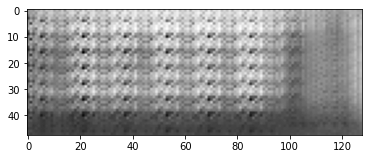

In [ ]:
noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)

plt.imshow(generated_image[0, :, :, 0], cmap='gray')